In [1]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import time_series
from sklearn.model_selection import train_test_split
import pandas as pd
from river import neighbors

from river import metrics

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'consumption' is your target variable
df = pd.read_csv('wheaterVersion.csv')

,datetime,Customer,Generator Capacity,Postcode,Consumption Category,temperature_2m,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,sunshine_duration,Month,DayOfWeek,consumption
0,2010-07-01,201,1.75,2291,GG,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0,7,3,0.0
1,2010-07-01,36,1.00,2137,GG,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0,7,3,0.0
4,2010-07-01,35,2.10,2284,GG,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0,7,3,0.0
7,2010-07-01,34,1.00,2082,GG,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0,7,3,0.0
9,2010-07-01,33,2.10,2303,GG,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0,7,3,0.0


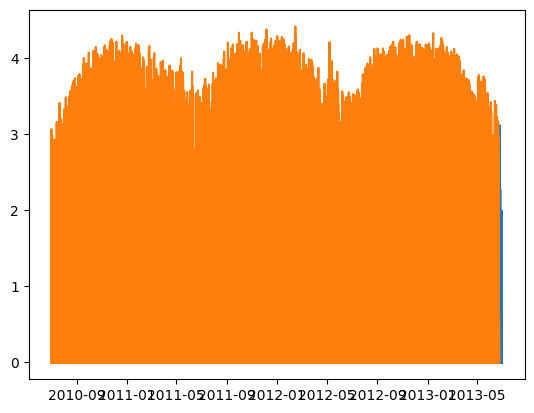

In [3]:

df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the DataFrame to only include rows where 'Consumption Category' is 'GG'
df = df[df['Consumption Category'] == 'GG']

#only keep full hours
df = df[df['datetime'].dt.minute == 0]

# Continue with the rest of your code
start_date = df["datetime"].min()
end_date = df['datetime'].max()

X = df.drop('consumption', axis=1)
y = df['consumption']

# Get month and day of the week from the date time column
X['Month'] = X['datetime'].dt.month
X['DayOfWeek'] = X['datetime'].dt.dayofweek

X_train = X
y_train = y

# Convert the training set back to DataFrame for the model training
train_df = pd.concat([X_train, y_train], axis=1)

#remove one week from the end of the training set to use as test set
test_df = train_df[train_df['datetime'] >= end_date - pd.Timedelta(days=7)]
train_df = train_df[train_df['datetime'] < end_date - pd.Timedelta(days=7)]
test_df.head()

#plot the test set
plt.plot(test_df['datetime'], test_df['consumption'])
test_df.head()

#plot the training set
plt.plot(train_df['datetime'], train_df['consumption'])
train_df.head()

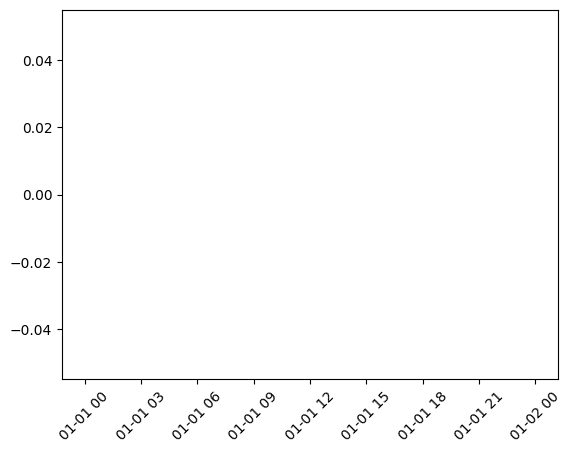

In [4]:
# Plot the last week of data
last_week = train_df[train_df['datetime'] > end_date - pd.Timedelta(days=7)]
plt.plot(last_week['datetime'],last_week['consumption'])
#rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [5]:
#creat a subset only for customer 36
customer_36 = train_df[train_df['Customer'] == 36]
print(customer_36.head())

#only keep datetime month, day of the week and consumption columns
customer_36 = customer_36[['datetime', 'Month', 'DayOfWeek', 'consumption','temperature_2m','precipitation','cloud_cover','sunshine_duration','cloud_cover_low','cloud_cover_mid','cloud_cover_high']]

test_customer_36 = test_df[test_df['Customer'] == 36]


customer_36.head()

                datetime  Customer  Generator Capacity  Postcode  \
1    2010-07-01 00:00:00        36                 1.0      2137   
1151 2010-07-01 01:00:00        36                 1.0      2137   
1607 2010-07-01 02:00:00        36                 1.0      2137   
2257 2010-07-01 03:00:00        36                 1.0      2137   
3058 2010-07-01 04:00:00        36                 1.0      2137   

     Consumption Category  temperature_2m  precipitation  cloud_cover  \
1                      GG           24.00            0.0         35.1   
1151                   GG           24.10            0.0         53.7   
1607                   GG           24.20            0.0         42.9   
2257                   GG           24.25            0.0         36.6   
3058                   GG           24.30            0.0         27.3   

      cloud_cover_low  cloud_cover_mid  cloud_cover_high  is_day  \
1                12.0              0.0              81.0     1.0   
1151            

,datetime,Month,DayOfWeek,consumption,temperature_2m,precipitation,cloud_cover,sunshine_duration,cloud_cover_low,cloud_cover_mid,cloud_cover_high
1,2010-07-01 00:00:00,7,3,0.0,24.00,0.0,35.1,3600.0,12.0,0.0,81.0
1151,2010-07-01 01:00:00,7,3,0.0,24.10,0.0,53.7,3600.0,32.0,0.0,83.0
1607,2010-07-01 02:00:00,7,3,0.0,24.20,0.0,42.9,3600.0,22.0,0.0,77.0
2257,2010-07-01 03:00:00,7,3,0.0,24.25,0.0,36.6,3600.0,16.0,0.0,74.0
3058,2010-07-01 04:00:00,7,3,0.0,24.30,0.0,27.3,3600.0,8.0,0.0,67.0


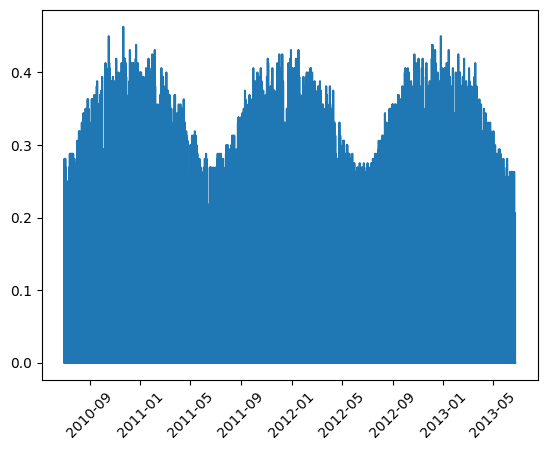

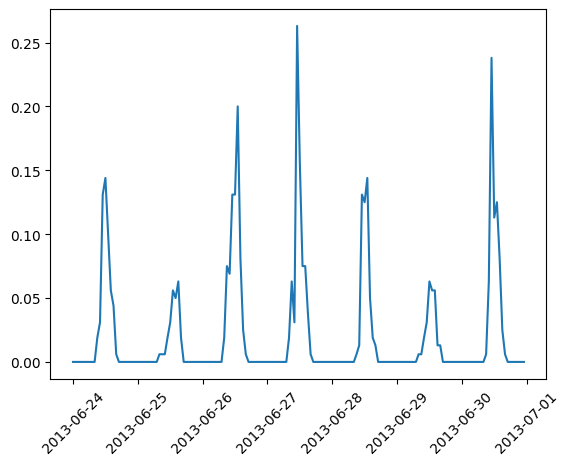

26135
169


In [6]:
#plot the consumption for customer 36
plt.plot(customer_36['datetime'], customer_36['consumption'])
plt.xticks(rotation=45)
plt.show()

#plot one week of data
last_week = test_customer_36[test_customer_36['datetime'] > end_date - pd.Timedelta(days=7)]
plt.plot(last_week['datetime'], last_week['consumption'])
plt.xticks(rotation=45)
plt.show()

#print the legth of the training and test set
print(len(customer_36))
print(len(test_customer_36))


In [12]:
from river import metrics
from river import neighbors
from river import preprocessing

# Define the parameter values that should be searched
k_range = list(range(1, 31))

best_mae = float('inf')
best_k = None

for k in k_range:
    model= (
        preprocessing.StandardScaler() |
        time_series.SNARIMAX(
            p=1,
            d=0,
            q=1,
            
            sp=0,
            sd=1,
            sq=1,
            m=24,
            regressor=(
                preprocessing.StandardScaler() |
                neighbors.KNNRegressor(
                n_neighbors=k,
                aggregation_method = 'weighted_mean',
            )
            )
        )
    )
    
    mae = metrics.MAE()
    
    for i, (_, row) in enumerate(customer_36.iterrows()):
        y = row['consumption']
        exog = row.drop('consumption').drop("datetime").to_dict()
        if i%1000 == 0:
            print(k,exog)
        if i > 0:  # Skip the first observation
            forecast = model.forecast(horizon=1, xs=[exog])  # forecast 1 step ahead
            mae.update(y, forecast[0])
        
        model.learn_one(exog, y)  # update the model with the current observation
    
    if mae.get() < best_mae:
        best_mae = mae.get()
        best_k = k

print(f"Best MAE: {best_mae} with k={best_k}")

1 {'Month': 7, 'DayOfWeek': 3, 'temperature_2m': 24.0, 'precipitation': 0.0, 'cloud_cover': 35.1, 'sunshine_duration': 3600.0, 'cloud_cover_low': 12.0, 'cloud_cover_mid': 0.0, 'cloud_cover_high': 81.0}
1 {'Month': 8, 'DayOfWeek': 2, 'temperature_2m': 26.1, 'precipitation': 0.3, 'cloud_cover': 40.800003, 'sunshine_duration': 0.0, 'cloud_cover_low': 21.0, 'cloud_cover_mid': 13.0, 'cloud_cover_high': 47.0}
1 {'Month': 9, 'DayOfWeek': 2, 'temperature_2m': 27.7, 'precipitation': 0.0, 'cloud_cover': 42.0, 'sunshine_duration': 174.12436, 'cloud_cover_low': 45.0, 'cloud_cover_mid': 0.0, 'cloud_cover_high': 5.0}
1 {'Month': 11, 'DayOfWeek': 2, 'temperature_2m': 23.9, 'precipitation': 0.0, 'cloud_cover': 74.399994, 'sunshine_duration': 3600.0, 'cloud_cover_low': 72.0, 'cloud_cover_mid': 0.0, 'cloud_cover_high': 32.0}
1 {'Month': 12, 'DayOfWeek': 1, 'temperature_2m': 21.2, 'precipitation': 0.9, 'cloud_cover': 100.0, 'sunshine_duration': 0.0, 'cloud_cover_low': 99.0, 'cloud_cover_mid': 100.0, 'clo